# Importing

References for continuing the project:

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#:~:text=%20Stationarity%20and%20detrending%20%28ADF%2FKPSS%29%20%E2%80%94%20statsmodels%20Stationarity,be%20stationary%20to%20make%20effective%20and%20precise%20predictions.

https://www.section.io/engineering-education/missing-values-in-time-series/

https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/

https://www.techopedia.com/definition/15008/reactive-power

https://circuitglobe.com/what-is-active-reactive-and-apparent-power.html

https://www.youtube.com/results?search_query=energy+forecasting

https://www.youtube.com/watch?v=rAYFuFNOCic

https://soumilshah1995.blogspot.com/2019/08/project-data-analysis-and.html

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bamboolib
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import kpss, adfuller
from pylab import rcParams
import statsmodels.api as sm

In [66]:
energy = pd.read_csv(r'..\data\processed\energy_cleaned.csv', index_col='Datetime')

In [67]:
energy = energy.reset_index()
energy['Datetime'] = pd.to_datetime(energy['Datetime'], infer_datetime_format=True)
energy.set_index('Datetime', inplace=True)
energy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972
...,...,...,...,...,...,...,...
2010-12-07,0.770538,0.198550,240.218646,3.397222,1.197222,0.448611,4.475000
2010-12-08,0.367846,0.117429,240.794931,1.623750,0.000000,0.356944,2.765278
2010-12-09,1.119508,0.139832,241.619722,4.755694,1.253472,1.444444,6.174306


# Correlation Matrix

The heatmap below shows that global active power and global intensity are directly correlated with each other and both strongly correlated with the three submeters. This makes sense since the equation for power is simply the product of the amperage squared and the resistance. This multicollinearity will have to be addressed in the preprocessing step. The heatmap does not reveal any strong inverse relationships.

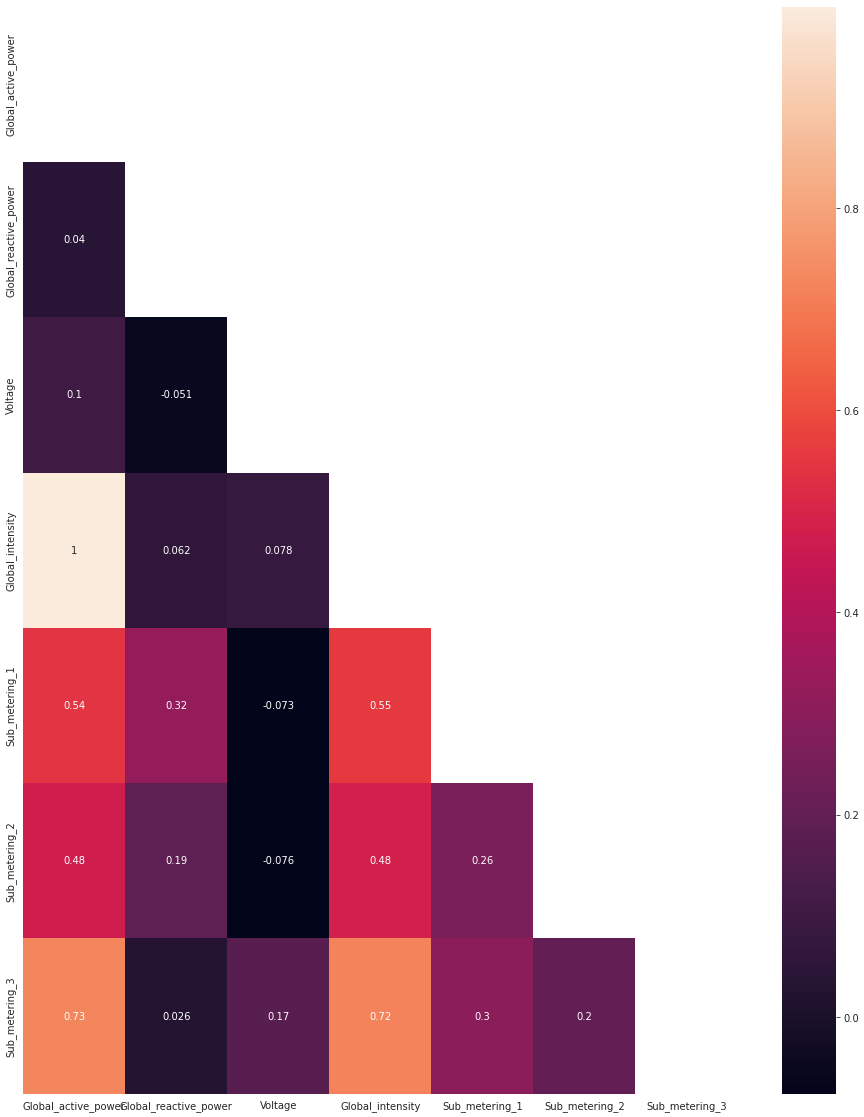

In [68]:
corr = energy.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True)

# Primary Feature: Sub Meter 3

The primary objective of this project is to forecast energy usage for HVAC systems. The following plot shows the time-series for the daily average reading for sub-meter 3, which monitors the electric water-heater and air conditioner. The series appears to be fairly stationary.

Text(0.5, 1.0, 'Daily Sub-meter 3 Avg Value')

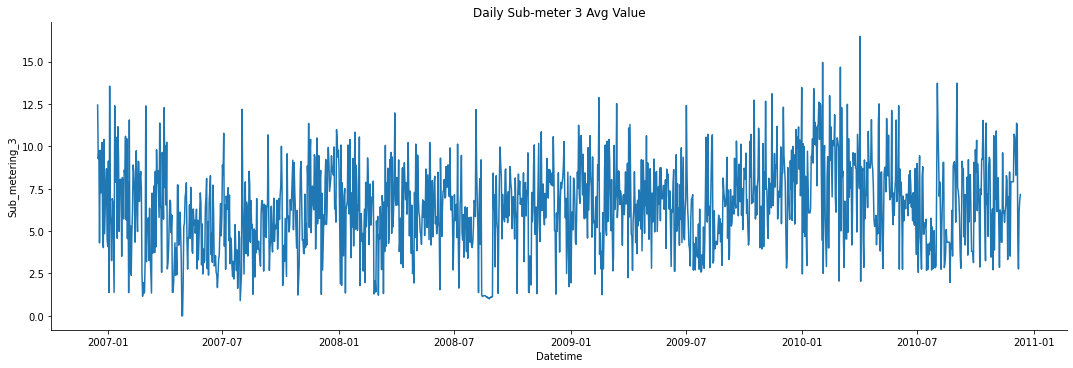

In [69]:
sns.relplot(x = 'Datetime', y='Sub_metering_3', data=energy, kind='line', aspect = 3)
plt.title('Daily Sub-meter 3 Avg Value')

# Stationarity Tests

The initial KPSS test failed and the initial ADFuller test passed. Taking the exponential transform and the first difference on the data passes both stationarity tests.

In [196]:
meter_3_exp_diff = np.exp(energy.Sub_metering_3).diff().dropna()

In [197]:
kpss(meter_3_exp_diff)

(0.00955578776894857,
 0.1,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [198]:
adfuller(meter_3_exp_diff)

(-13.158533228504306,
 1.3219003284019312e-24,
 23,
 1432,
 {'1%': -3.4349247631306237,
  '5%': -2.8635604442944658,
  '10%': -2.5678456715029183},
 41080.94579756741)

# Decomposition

Decomposing the meter daily average values on a monthly basis reveals regular low periods every August.

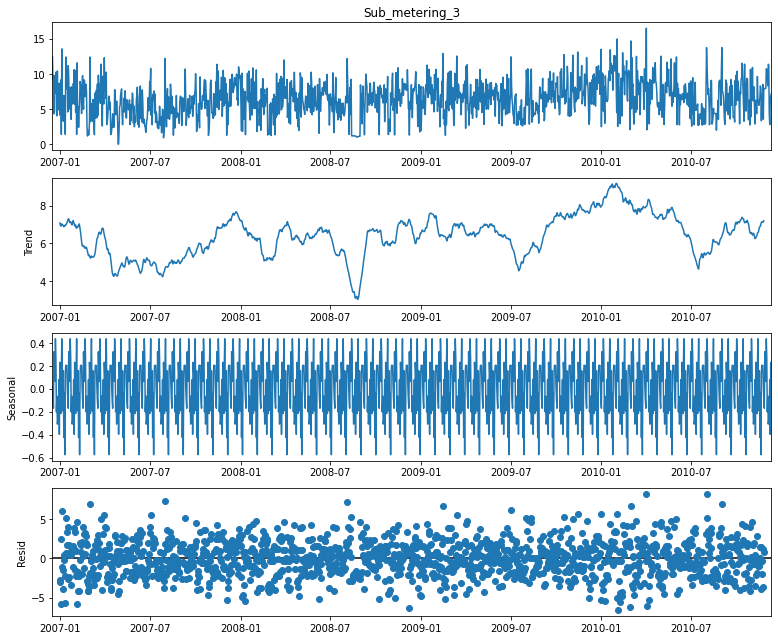

In [72]:
rcParams['figure.figsize'] = 11,9
decomp = sm.tsa.seasonal_decompose(energy.Sub_metering_3, period = 30, model = 'additive')
decomp.plot()
plt.show()

# Autocorrelation

I plotted the autocorrelation and partial autocorrelation to try to identify ideal lag values for an ARMA model. The results from the two plots suggest that we should try an MA(1) model since the ACF cuts off at lag 1 and the PACF tails off gradually.

Note: The high autocorrelation coefficients outside the margins of uncertainty indicate a statistically significant autocorrelation.

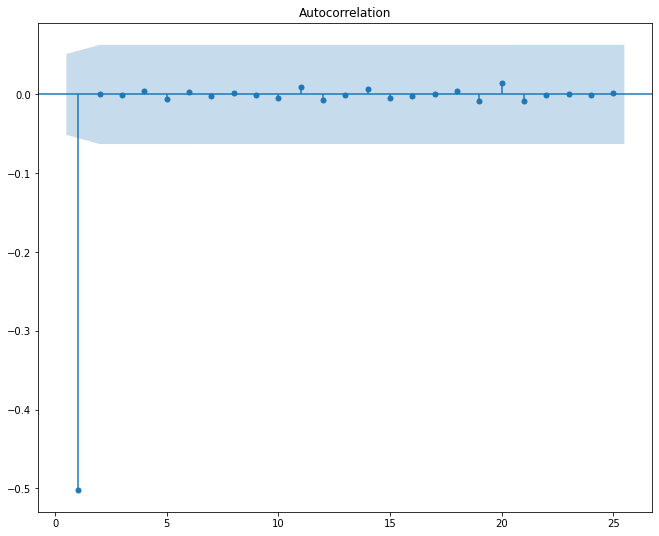

In [199]:
tsaplots.plot_acf(meter_3_exp_diff, lags=25, zero=False)
plt.show()

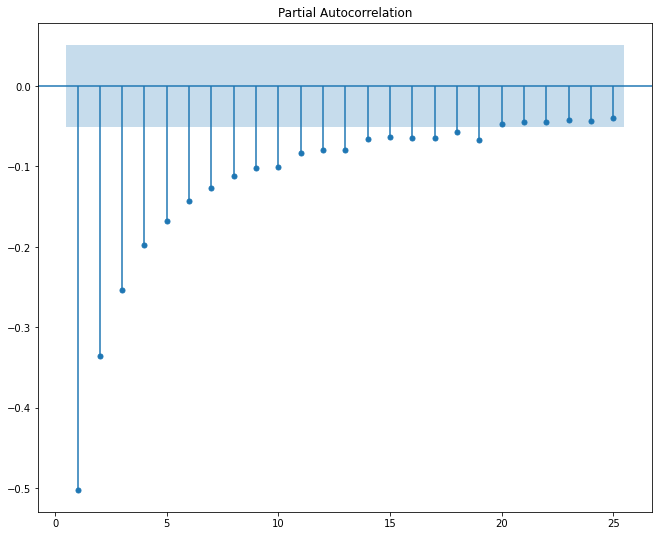

In [200]:
tsaplots.plot_pacf(meter_3_exp_diff, lags=25, zero=False)
plt.show()

# Global Active Power

Lastly, I plotted the remaining time-series variables to visualize the distributions on a yearly and monthly basis. The global active power yearly median stays consistent, with a decrease in the overall variance across time. The variable shows a seasonal low in the warmer months of summer.

In [125]:
years = np.array(energy.index.year)

In [126]:
months = np.array(energy.index.month)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



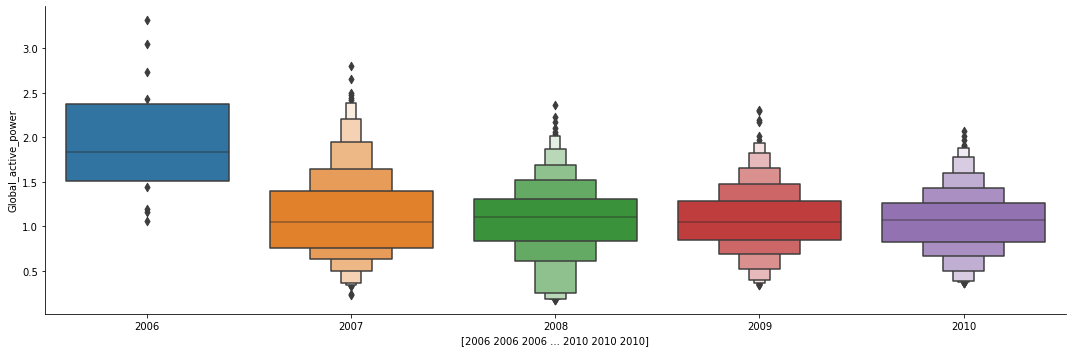

In [127]:
sns.catplot(x = years, y = 'Global_active_power', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



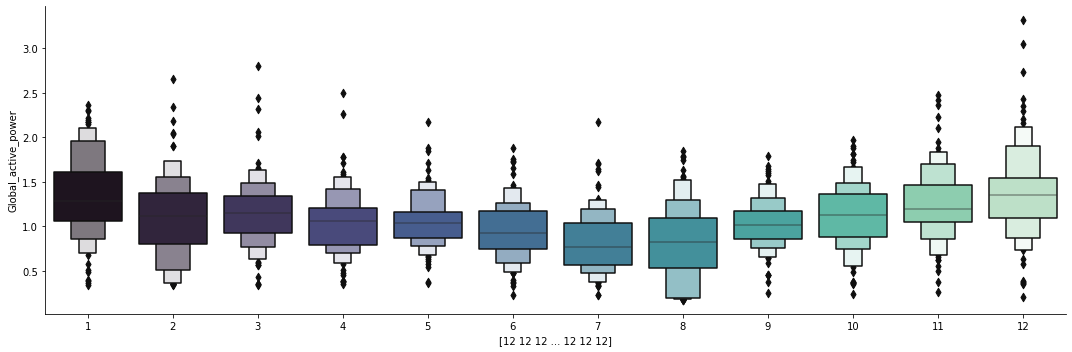

In [144]:
sns.catplot(x = months, y = 'Global_active_power', data=energy, kind='boxen', aspect = 3, palette='mako')

# Global Reactive Power

The median annual global reactive power seems to be increasing over time. The global reactive power reaches a peak in the summer months.

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



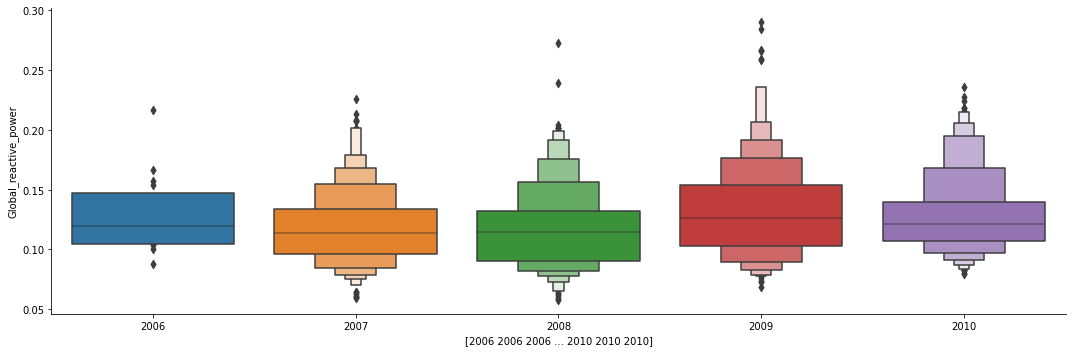

In [114]:
sns.catplot(x = years, y = 'Global_reactive_power', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



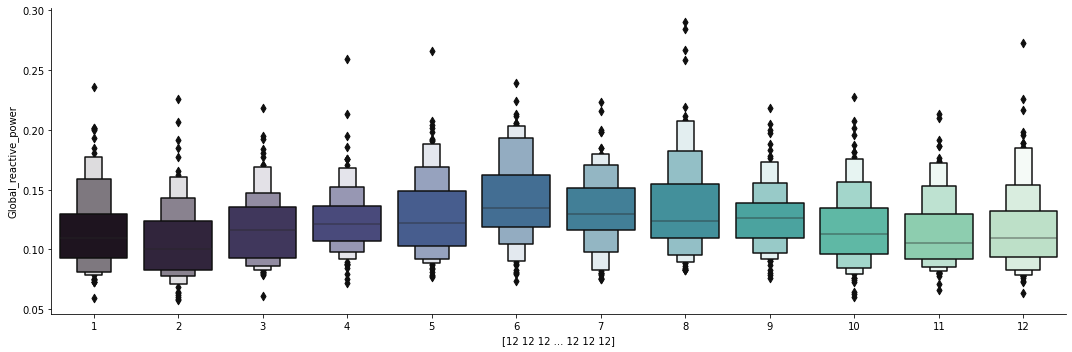

In [143]:
sns.catplot(x = months, y = 'Global_reactive_power', data=energy, kind='boxen', aspect = 3, palette='mako')

# Voltage

As you would hope, the voltage level remains constant throughout the year and across the years, though 2007 had significantly more variance than other years.

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



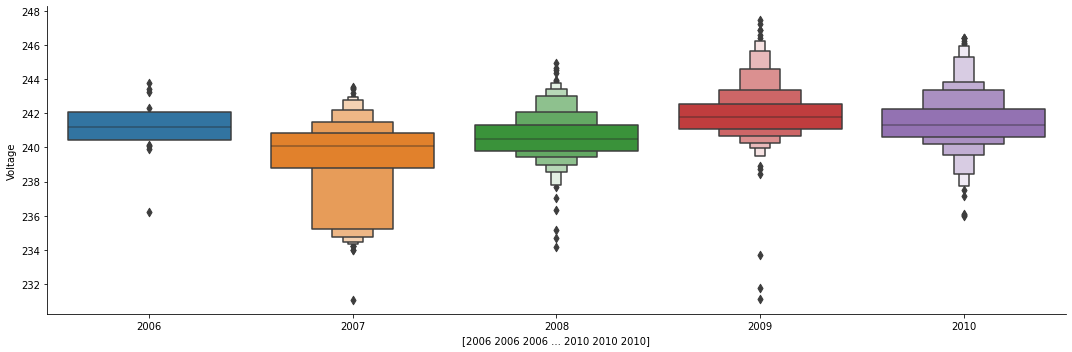

In [115]:
sns.catplot(x = years, y = 'Voltage', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



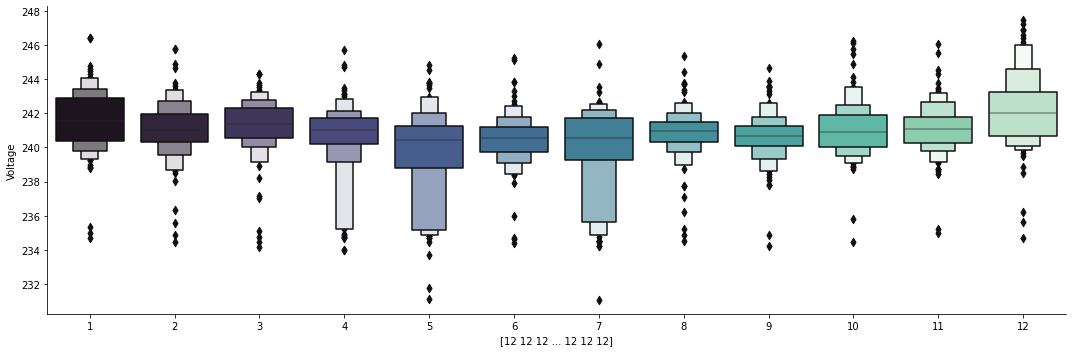

In [142]:
sns.catplot(x = months, y = 'Voltage', data=energy, kind='boxen', aspect = 3, palette='mako')

# Global Intensity

Global intensity is directly and highly correlated with global active power, so the same findings apply to this variable.

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



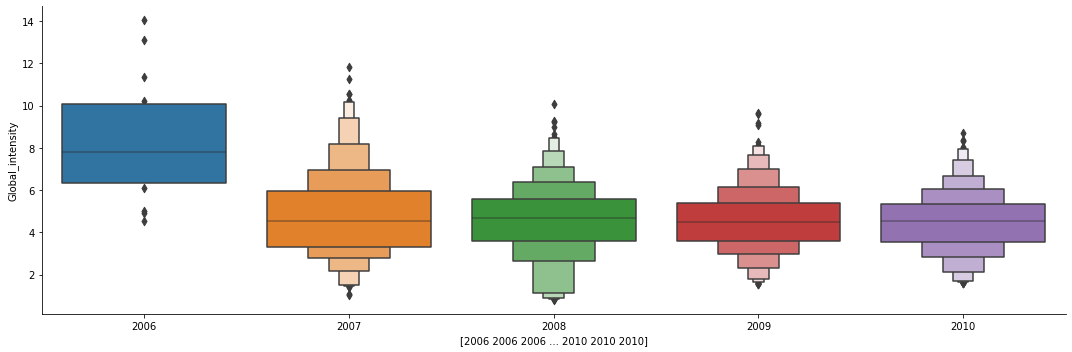

In [116]:
sns.catplot(x = years, y = 'Global_intensity', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



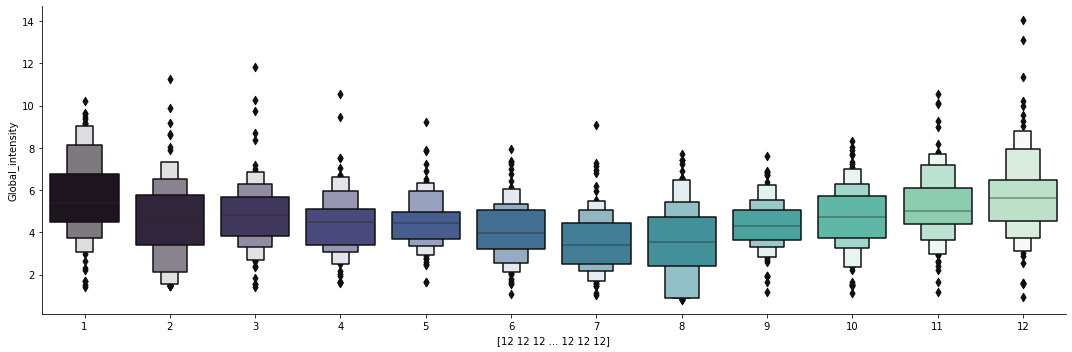

In [141]:
sns.catplot(x = months, y = 'Global_intensity', data=energy, kind='boxen', aspect = 3, palette='mako')

# Sub-Meter 1

Sub-meter 1 measures the watt-hours of active energy used in the kitchen, including appliances like a dishwasher, oven, and microwave. The median values stay and variance stay relatively stable throughout the years and across the months of the year.

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



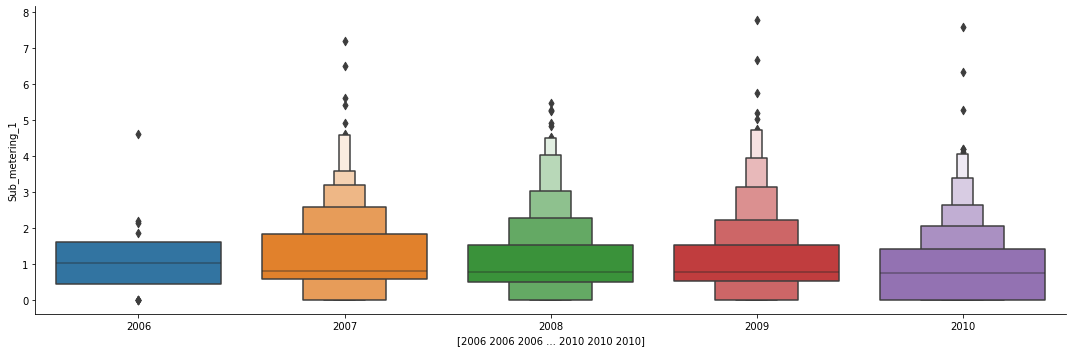

In [117]:
sns.catplot(x = years, y = 'Sub_metering_1', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



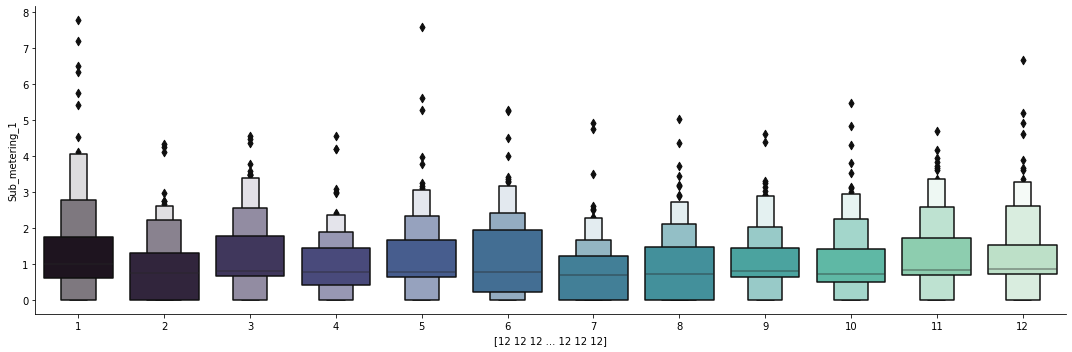

In [140]:
sns.catplot(x = months, y = 'Sub_metering_1', data=energy, kind='boxen', aspect = 3, palette='mako')

# Sub-Meter 2

Sub-meter 2 measures the watt-hours of active energy in the laundry room, including a washing machine, dryer, refrigerator, and light. The median values appear to be stable across time, but interestingly the summer months exhibit a smaller variance in values in comparison to the rest of the year.

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



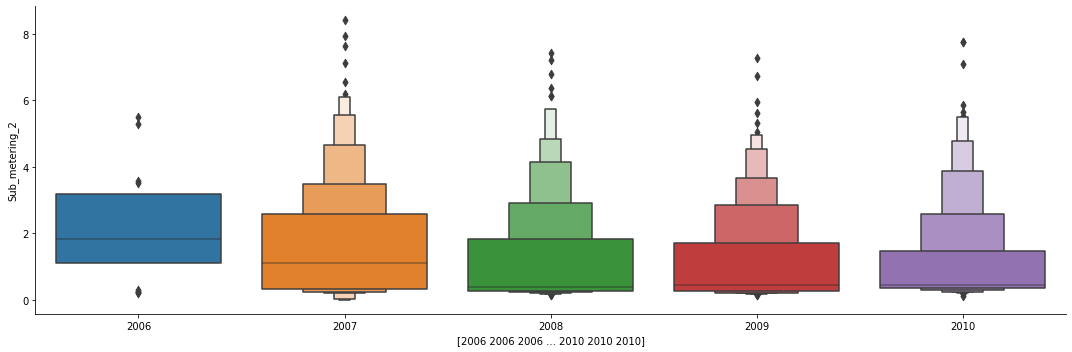

In [118]:
sns.catplot(x = years, y = 'Sub_metering_2', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



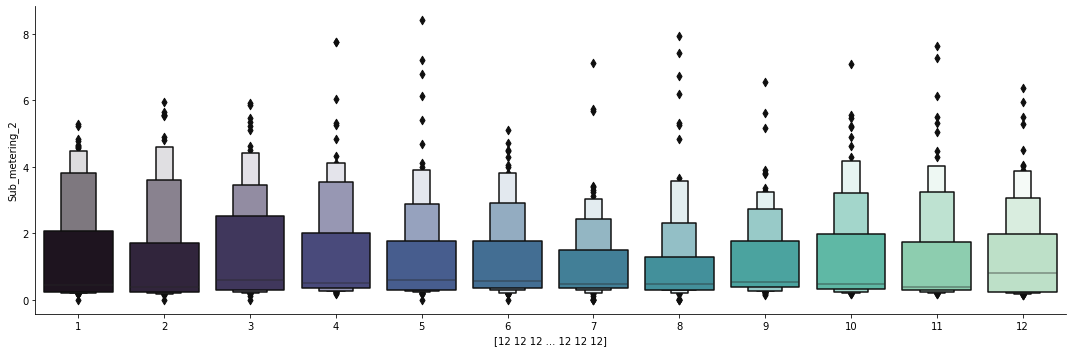

In [138]:
sns.catplot(x = months, y = 'Sub_metering_2', data=energy, kind='boxen', aspect = 3, palette='mako')

# Sub-Meter 3

Lastly, sub-meter 3, the variable of interest, captures the watt-hours of active energy used by the air conditioning unit and the water heater. This variable exhibits a gradual increase in the median value of the years, and a seasonal low during the summer months. 

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



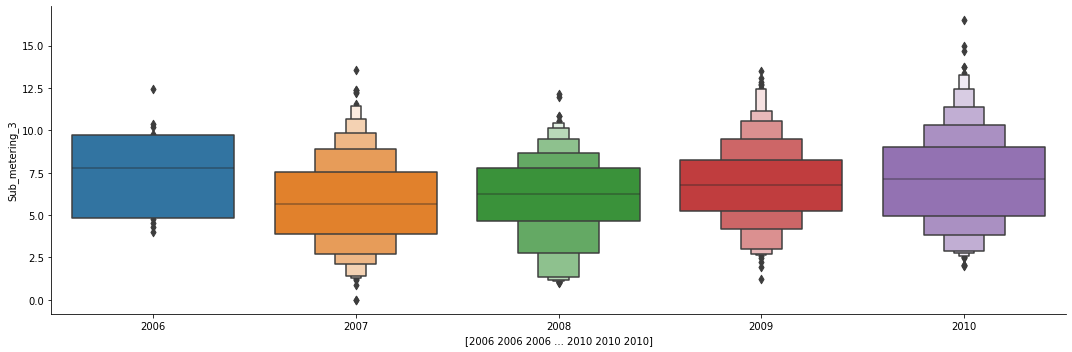

In [119]:
sns.catplot(x = years, y = 'Sub_metering_3', data=energy, kind='boxen', aspect = 3)

C:\Users\jjsun\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



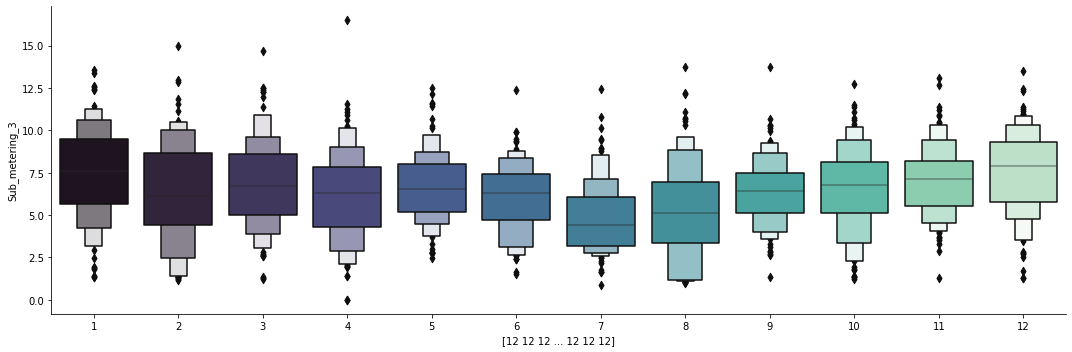

In [137]:
sns.catplot(x = months, y = 'Sub_metering_3', data=energy, kind='boxen', aspect = 3, palette='mako')